<a href="https://colab.research.google.com/github/thomasawolff/YouTube-Video-Comments-Project/blob/main/UnsupervisedLearningYouTubeData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:

  
import re
import os
import sys
import nltk
import math
import json
import nltk.corpus
import operator
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
nltk.download('punkt')
nltk.download('words')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
from google.colab import drive
from wordcloud import WordCloud
from scipy.stats import pearsonr
from scipy.stats import kurtosis
import tensorflow_hub as hub
import tensorflow.compat.v1 as tf
from nltk import ne_chunk
from textblob import TextBlob
from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as sch
from multiprocessing import Pool
import matplotlib.pyplot as plt
from sklearn.neighbors import KernelDensity
from scipy.stats import norm
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from collections import Counter
from nltk.tokenize import word_tokenize
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import CountVectorizer


drive.mount('/content/drive')
print(os.chdir('/content/drive/MyDrive/Research_Methods/Course_Project/YouTube_Data/Unicode_Files'))
#print(os.listdir())
url = 'youTubeVideosUTF.csv'


def jSonYield():
    ids = []
    titleList = []
    data = json.load(open('US_category_id.json'))
    pos0 = data.keys()
    pos1 = data.get('items')
    try:
        for i in range(0,len(pos1)):
            id_ = pos1[i]['id']
            title = pos1[i]['snippet']['title']
            ids.append(id_)
            titleList.append(title)
            cats = dict(zip(ids,titleList))
    except IndexError: pass
    return cats


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
None


In [81]:
class textAnalytics(object):

    def __init__(self,file1,
                 numClusters=2,
                 category=None,
                 channel=None,
                 dataFeature1=None,
                 dataFeature2=None,
                 dataFeature3=None,
                 dataFeature4=None,
                 sentiment = None
                 ):

        dict_ = jSonYield()
        self.limit = 100
        self.stringsList = []
        self.sentiment = sentiment
        self.number_clusters = numClusters
        self.dataFeature1 = dataFeature1
        self.dataFeature2 = dataFeature2
        self.dataFeature3 = dataFeature3
        self.dataFeature4 = dataFeature4
        categoryPick = pd.DataFrame(dict_.items(),columns=[self.dataFeature2,'category'])
        review_df_All = pd.read_csv(file1,low_memory=False)
        self.token_pattern = '(?u)\\b\\w+\\b'
        categoryPick[self.dataFeature2] = categoryPick[self.dataFeature2].astype(int)
        review_df_All = pd.merge(categoryPick, review_df_All, on = self.dataFeature2)
        videoTitles = pd.read_csv('YouTubeVideoTitles.csv')
        review_df_All = pd.merge(videoTitles, review_df_All, on = dataFeature1)
        review_df_All = review_df_All.loc[review_df_All['channel'] == channel]
        self.stopWords = stopwords.words('english')
        try:
            print('There are ',len(review_df_All),' comments on this topic')
            self.dataComm = review_df_All.sample(10000).drop_duplicates()
        except ValueError:
            print('There are ',len(review_df_All),' comments on this topic')
            self.dataComm = review_df_All.drop_duplicates()

                
    def sentimentAnalysis(self):
        pol = []
        sub = []
        for i in self.dataComm.commentText.values:
            try:
                analysis = TextBlob(i)
                pol.append(round(analysis.sentiment.polarity,2))
            except:
                pol.append(0)

        for i in self.dataComm.commentText.values:
            try:
                analysis = TextBlob(i)
                sub.append(round(analysis.sentiment.subjectivity,2))
            except:
                sub.append(0)
        self.dataComm['polarity']=pol
        self.dataComm['subjectivity']=sub
        self.dataComm.loc[self.dataComm['polarity'] < 0, 'sentimentBucket'] = -1
        self.dataComm.loc[self.dataComm['polarity'] == 0, 'sentimentBucket'] = 0
        self.dataComm.loc[self.dataComm['polarity'] > 0, 'sentimentBucket'] = 1
        self.dataComm = self.dataComm.loc[self.dataComm['sentimentBucket'].astype(float) == float(self.sentiment)]
        #dataComm .to_csv('youTubeVideosSentimentAnalysisSample10000.csv',sep=',',encoding='utf-8')
        #print(dataComm )
        ##                    videoID       categoryID  views  ...    replies  polarity   subjectivity
        ##          251449  LLGENw4C1jk          17   1002386  ...      0.0      0.50          0.50
        ##          39834   3VVnY86ulA8          22    802134  ...      0.0      0.00          0.10
        ##          203460  iA86imHKCMw          17   3005399  ...      0.0     -0.08          0.69
        ##          345225  RRkdV_xmYOI          23    367544  ...      0.0      0.13          0.76
        ##          402953  vQ3XgMKAgxc          10  51204658  ...      0.0      0.25          0.50

        
    def dataModify(self):
        self.sentimentAnalysis()
        self.dataComm  = self.dataComm[[self.dataFeature1,self.dataFeature2,self.dataFeature4,'polarity','subjectivity','sentimentBucket']]
        self.X = self.dataComm.iloc[:,[self.dataComm.columns.get_loc('polarity'),self.dataComm.columns.get_loc('subjectivity')]].values

      
    def kMeansElbow(self):
        self.dataModify()
        # using the elbow method to find optimal number of clusters
        wcss = []
        for i in range(1, 11):
           kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter=300,n_init=10,random_state=0)
           kmeans.fit(self.X)
           wcss.append(kmeans.inertia_)
        plt.plot(range(1, 11),wcss)
        plt.title('The Elbow Method')
        plt.xlabel('Number of Data Clusters')
        plt.ylabel('WCSS')
        plt.show()

      
    def kMeansClustering(self):
        self.dataModify()
        self.kmeans = KMeans(self.number_clusters, init = 'k-means++',max_iter=300,n_init=10)
        self.y_kmeans = self.kmeans.fit_predict(self.X)
        self.dataComm['clusters'] = self.y_kmeans
       

    def kMeansVisualizer(self):
        self.kMeansClustering()
        # visualizing the clusters using K-means
        for i in range(0,self.number_clusters):
           plt.scatter(self.X[self.y_kmeans == i, 0], self.X[self.y_kmeans == i, 1], s = 100)
           #plt.scatter(self.kmeans.cluster_centers_[:,0],self.kmeans.cluster_centers_[:,1],s=50,c='yellow',label='Centroids')
        plt.title('Clusters of Sentiment vs Subjectivity: K-Means Method')
        plt.xlabel('Sentiment Value')
        plt.ylabel('Subjectivity Value')
        plt.legend(set(self.y_kmeans))
        plt.show()
        cluster = int(input('Which cluster do you want to analyze?: '))
        self.dataComm = self.dataComm.loc[self.dataComm['clusters'] == cluster]
        self.dataComm.to_csv('dataComm.csv')


    def wordCount(self):
        dataComm = pd.read_csv('dataComm.csv')
        for line in dataComm[self.dataFeature4]:
            wordsTokens = word_tokenize(line)
            self.stringsList.append(Counter(wordsTokens))
        ##print(self.stringsList)
        ##  Counter({'.': 11, 'the': 9, 'and': 8, 'was': 8, 'It': 5, 'I': 5, 'it': 4, 'their': 4


    def stringCleaning(self):
        self.wordCount()
        lengthList = []
        punctuationList = ['-?','!',',',':',';','()',"''",'.',"``",'|','^','..','...','--','=']
        for i in range(0,self.limit):
            try:
                for words in self.stringsList[i]:
                    if len(words)>0:
                        lengthList.append(words)
            except IndexError: pass
        post_punctuation = [word for word in lengthList if word not in punctuationList]
        noStopWords = [word for word in post_punctuation if word not in self.stopWords]
        self.postPunctCount = Counter(noStopWords)
        # print(self.postPunctCount)
        ##        Counter({'I': 9, "n't": 6, 'The': 5, 'go': 5, 'good': 5, "'s": 5,
        ##                 'My': 4, 'It': 4, 'place': 4, 'menu': 4, ')': 4, 'outside': 3,
        ##                 'food': 3, 'like': 3, "'ve": 3, 'amazing': 3, 'delicious': 3,
        ##                 'came': 3, 'wait': 3, 'back': 3, 'They': 3, 'evening': 3, 'try': 3,
        ##                 'one': 3, '(': 3, 'awesome': 3,'much': 3, 'took': 2, 'made': 2,
        ##                 'sitting': 2, 'Our': 2, 'arrived': 2, 'quickly': 2, 'looked': 2, ....


    def tagsMaker(self):
        # If you want to run this code, install Ghostscript first
        self.stringCleaning()
        tags = nltk.pos_tag(self.postPunctCount)
        grams = ne_chunk(tags)
        grammers = r"NP: {<DT>?<JJ>*<NN>}"
        chunk_parser = nltk.RegexpParser(grammers)
        chunk_result = chunk_parser.parse(grams)
        print(chunk_result)
        ##        (ORGANIZATION General/NNP Manager/NNP Scott/NNP Petello/NNP)
        ##          (NP egg/NN)
        ##          Not/RB
        ##          (NP detail/JJ assure/NN)
        ##          albeit/IN
        ##          (NP rare/JJ speak/JJ treat/NN)
        ##          (NP guy/NN)
        ##          (NP respect/NN)
        ##          (NP state/NN)
        ##          'd/MD
        ##          surprised/VBN
        ##          walk/VB
        ##          totally/RB
        ##          satisfied/JJ
        ##          Like/IN
        ##          always/RB
        ##          say/VBP
        ##          (PERSON Mistakes/NNP)


    def wordCloudVisualizer(self):
        dataComm = pd.read_csv('dataComm.csv')
        wordcloud = WordCloud(
            background_color='white',
            stopwords= ["dtype",'commentText','object','video','Name']+stopwords.words('english'),
            max_words=200,
            max_font_size=40, 
            scale=3
            ).generate(str(dataComm['commentText']))
        fig = plt.figure(1, figsize=(6,6))
        plt.title('Word cloud of chosen cluster')
        plt.axis('off')
        plt.imshow(wordcloud)
        plt.show()


    # this project uses GPU processing in tensorflow for embedding the comments
    def embed_useT(self,module):
        with tf.Graph().as_default():
            gpus = tf.config.experimental.list_physical_devices('GPU')
            if gpus:
                try:
                    tf.config.experimental.set_virtual_device_configuration(
                    gpus[1],
                    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000),
                      tf.config.experimental.VirtualDeviceConfiguration(memory_limit=4000)])
                    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
                    print(len(gpus), "Physical GPU,", len(logical_gpus), "Logical GPUs")
                except RuntimeError as e:
                    print(e)
                
            else: tf.config.experimental.list_physical_devices(device_type='CPU')
        
            sentences = tf.placeholder(tf.string)
            embed = hub.Module(module)
            embeddings = embed(sentences)
            session = tf.train.MonitoredSession()
        return lambda x: session.run(embeddings, {sentences: x})


    # visualizes the heatmap for correlation from inner product between the sentence vectors.
    def plot_similarity(self):
        dataComm = pd.read_csv('dataComm.csv')
        comments = dataComm['commentText'].sample(10)
        self.random = '"'+comments+'"'
        embed_fn = self.embed_useT(r'/content/drive/MyDrive/Research_Methods/Course_Project/YouTube_Data/Unicode_Files')
        encoding_matrix = embed_fn(self.random)
        print(encoding_matrix)
        products = np.inner(encoding_matrix, encoding_matrix)
        mask = np.zeros_like(products, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        sns.set(font_scale=.8)
        g = sns.heatmap(
            products,
            xticklabels=[textwrap.fill(e,15) for e in self.random],
            yticklabels=[textwrap.fill(e,40) for e in self.random],
            vmin=0,
            vmax=1,
            cmap="YlOrRd",
            mask=mask)
        g.figure.set_size_inches(10,8)
        plt.xticks(rotation=0)
        g.set_title("Semantic Textual Similarity")
        plt.show()

Type Done to leave or press enter 
Do you know how many clusters you want? Yes/No: yes
How many clusters do you want?: 3
Which channel do you want to analyze?: ESPN
Which sentiment do you want? (1.0 for positive,0.0 for nuetral,-1.0 for negative): 1
There are  2247  comments on this topic
There are  2247  comments on this topic


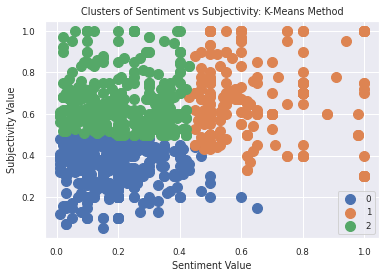

Which cluster do you want to analyze?: 2


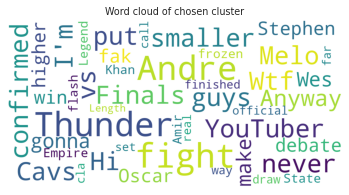

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
[[-0.07291625  0.03169365 -0.02669782 ...  0.01468259 -0.02222001
  -0.01047018]
 [ 0.00142696  0.0235505   0.01610151 ...  0.01510119 -0.04414282
   0.06067074]
 [ 0.02323577  0.03967966 -0.06669762 ...  0.01394214 -0.00271702
  -0.02992925]
 ...
 [ 0.05046094  0.06131797  0.00133988 ...  0.02905698 -0.03208145
  -0.03223911]
 [ 0.05025059 -0.00965875 -0.00157769 ...  0.08498461  0.07350405
   0.01993887]
 [-0.01421198  0.03489604 -0.0315511  ...  0.05153437 -0.00741143
  -0.05561145]]


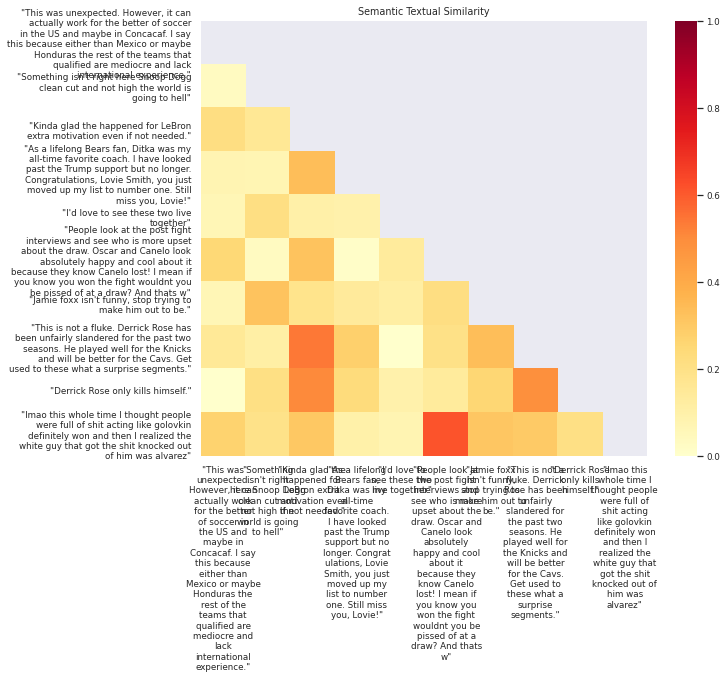

Type Done to leave or press enter done


SystemExit: ignored

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2890: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [82]:

while True:
    exit_ = input('Type Done to leave or press enter ')
    if exit_.lower() == 'done': sys.exit(0)
    clusters = input('Do you know how many clusters you want? Yes/No: ')
    if clusters.lower() == 'yes':
        try:
            try:
                go = textAnalytics(url,
                                   numClusters = int(input('How many clusters do you want?: ')),
                                   channel = input('Which channel do you want to analyze?: '),
                                   #category = input('Which category do you want to analyze?: '),
                                   dataFeature1 = 'videoID', # First of Four columns in dataset
                                   dataFeature2 = 'categoryID',
                                   #dataFeature3 = 'views',
                                   dataFeature4 = 'commentText',
                                   sentiment = input('Which sentiment do you want? (1.0 for positive,0.0 for nuetral,-1.0 for negative): '))

                #go.kMeansElbow()
                go.kMeansVisualizer()
                go.wordCloudVisualizer()
                go.plot_similarity()
            except ValueError:
                print('You may have entered bad data')
                pass
        except TypeError:
            print('You Entered an invalid cluster number, try: '+str(int(go.cluster)-1))
            pass
    else:
         try:
            try:
                 go = textAnalytics(url,
                                   #category = input('Which category do you want to analyze?: '),
                                   channel = input('Which channel do you want to analyze?: '),
                                   dataFeature1 = 'videoID', # First of Four columns in dataset
                                   #dataFeature2 = 'categoryID',
                                   dataFeature3 = 'views',
                                   dataFeature4 = 'commentText',
                                   sentiment = input('Which sentiment do you want? (1.0 for positive,0.0 for nuetral,-1.0 for negative): '))

                 go.kMeansElbow()
            except ValueError:
                print('You may have entered bad data')
                pass
         except TypeError:
            print('You Entered an invalid cluster number, try: '+str(int(go.cluster)-1))
            